### Adopted from https://github.com/zama-ai/concrete-ml/tree/main/use_case_examples/cifar/cifar_brevitas_finetuning with modifications

### Import the required packages.

In [2]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00


In [3]:
import random
import warnings
from copy import deepcopy

import torch
#from cifar_utils import get_dataloader, plot_dataset, plot_history, torch_inference, train
#from models import Fp32VGG11

warnings.filterwarnings("ignore")

### Utils

In [4]:
import pickle as pkl
import random
import sys
import warnings
from collections import OrderedDict
from pathlib import Path
from time import time
from typing import Callable, Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import top_k_accuracy_score
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

#from concrete.ml.torch.compile import compile_brevitas_qat_model

warnings.filterwarnings("ignore", category=UserWarning)


DATASETS_ARGS = {
    "SPEC": {
        "dataset": 'arieg/cluster00_large_150',
        "dataset_type": 'huggingface',
        "mean": [0.4914, 0.4822, 0.4465],
        "std": [0.247, 0.243, 0.261],
        "train_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.RandomResizedCrop((224,224)),
            ]
        ),
        "test_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.RandomResizedCrop((224,224)),
            ]
        ),
    },
    "CIFAR_10": {
        "dataset": datasets.CIFAR10,
        "mean": [0.4914, 0.4822, 0.4465],
        "std": [0.247, 0.243, 0.261],
        "train_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                # We apply data augmentation in order to prevent overfitting
                transforms.RandomRotation(5, fill=(1,)),
                transforms.GaussianBlur(kernel_size=(3, 3)),
                transforms.RandomHorizontalFlip(0.5),
            ]
        ),
        "test_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            ]
        ),
    },
    "CIFAR_100": {
        "dataset": datasets.CIFAR100,
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225],
        "train_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                # We apply data augmentation in order to prevent overfitting
                transforms.RandomRotation(5, fill=(1,)),
                transforms.GaussianBlur(kernel_size=(3, 3)),
                transforms.RandomHorizontalFlip(0.5),
            ]
        ),
        "test_transform": transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ]
        ),
    },
}


def get_torchvision_dataset(
    dataset_config: Dict,
    train_set: bool,
    max_examples: Optional[int] = None,
):
    """Get train or testing data-set.

    Args:
        param (Dict): Set of hyper-parameters to use based on the selected torchvision data-set.
            It must contain: data-set transformations (torchvision.transforms.Compose), and the
            data-set_size (Optional[int]).
        train_set (bool): Use train data-set if True, else testing data-set

    Returns:
        A torchvision data-sets.
    """

    transform = dataset_config["train_transform"] if train_set else dataset_config["test_transform"]
    dataset = dataset_config["dataset"](
        download=True, root="./data", train=train_set, transform=transform
    )

    if max_examples is not None:
        assert len(dataset) > max_examples, "Invalid max number of examples"
        dataset = torch.utils.data.random_split(
            dataset,
            [max_examples, len(dataset) - max_examples],
        )[0]

    return dataset

from datasets import load_dataset



def get_dataloader(
    param: Dict,
    path: str = None,
) -> Tuple[DataLoader, DataLoader]:
    """Returns the training and the test loaders of either CIFAR-10 or CIFAR-100 data-set.

    The CIFAR data-set contains of `32*32` colored images.

    Args:
        param (Dict): Set of hyper-parameters to use depending on whether
           CIFAR-10 or CIFAR-100 is used.
        path: if not None, load datasets from the path
    Return:
        Tuple[DataLoader, DataLoader]: Training and test data loaders.
    """

    g = torch.Generator()
    g.manual_seed(param["seed"])
    np.random.seed(param["seed"])
    torch.manual_seed(param["seed"])
    random.seed(param["seed"])

    max_examples = param.get("dataset_size", None)
    dataset_type = DATASETS_ARGS[param["dataset_name"]].get("dataset_type", "torchvision")

    if path is None:
        if dataset_type == "torchvision":
            train_dataset = get_torchvision_dataset(
                DATASETS_ARGS[param["dataset_name"]], train_set=True, max_examples=max_examples
            )

            test_dataset = get_torchvision_dataset(
                DATASETS_ARGS[param["dataset_name"]], train_set=False, max_examples=max_examples
            )
        else:                                                                             # huggingface
            train_dataset = get_huggingface_dataset(
                DATASETS_ARGS[param["dataset_name"]], train_set=True, max_examples=max_examples
            )

            test_dataset = get_huggingface_dataset(
                DATASETS_ARGS[param["dataset_name"]], train_set=False, max_examples=max_examples
            )
    else:
        dataset_name = str(DATASETS_ARGS[param["dataset_name"]]["dataset"]).split('/')[1]
        train_dataset = torch.load(f"{path}/{dataset_name}_train.pt")
        test_dataset = torch.load(f"{path}/{dataset_name}_test.pt")

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=param["batch_size"],
        shuffle=True,
        drop_last=True,
        generator=g,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=param["batch_size"],
        shuffle=True,
        drop_last=True,
    )

    return (train_loader, test_loader)


def plot_history(param: Dict, load: bool = False) -> None:
    """Display the loss and accuracy for the test and training sets.

    Args:
        param (Dict): Set of hyper-parameters to use depending on whether
            CIFAR-10 or CIFAR-100 is used.
        load (bool): If True, we upload the stored param.
    Returns:
        None.
    """

    if load:

        with open(
            f"{param['dir']}/{param['training']}/{param['dataset_name']}_history.pkl", "br"
        ) as f:
            param = pkl.load(f)

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    # Plot the training and test loss.
    axes[0].plot(
        range(len(param["loss_train_history"])),
        param["loss_train_history"],
        label="Train loss",
        marker="o",
    )
    axes[0].plot(
        range(len(param["loss_test_history"])),
        param["loss_test_history"],
        label="Test loss",
        marker="s",
    )

    axes[0].set_title("Loss")
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].legend(loc="best")
    axes[0].grid(True)

    # Plot the training and test accuracy.
    axes[1].plot(
        range(len(param["accuracy_train"])),
        param["accuracy_train"],
        label="Train accuracy",
        marker="o",
    )
    axes[1].plot(
        range(len(param["accuracy_test"])),
        param["accuracy_test"],
        label="Test accuracy",
        marker="s",
    )

    axes[1].set_title("Top-1 accuracy")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].legend(loc="best")
    axes[1].grid(True)

    fig.tight_layout()
    plt.show()


def plot_baseline(param: Dict, data: DataLoader, device: str) -> None:
    """
    Display the test accuracy given `param` arguments
    that we got using Transfer Learning and QAT approaches.

    Args:
        param (Dict): Set of hyper-parameters to use depending on whether
            CIFAR-10 or CIFAR-100 is used.
        data (DataLoader): Test set.
        device (str): Device type.

    Returns:
        None
    """
    # The accuracy of the counterpart pre-trained model in fp32 will be used as a baseline.
    # That we try to catch up during the Quantization Aware Training.
    checkpoint = torch.load(f"{param['dir']}/{param['pre_trained_path']}", map_location=device)
    fp32_vgg = Fp32VGG11(param["output_size"])
    fp32_vgg.load_state_dict(checkpoint)
    baseline = torch_inference(fp32_vgg, data, param, device)

    plt.plot(
        range(len(param["accuracy_test"])),
        param["accuracy_test"],
        marker="o",
        label="Test accuracy",
    )
    plt.text(x=0, y=baseline + 0.01, s=f"Baseline = {baseline * 100: 2.2f}%", fontsize=15, c="red")
    plt.plot(range(len(param["accuracy_test"])), [baseline] * len(param["accuracy_test"]), "r--")

    plt.title(f"Accuracy on the testing set with {param['dataset_name']}")
    plt.legend(loc="best")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.xlim(-0.3, 4.2)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()


def plot_dataset(data_loader: DataLoader, param: Dict, n: int = 10) -> None:
    """Visualize some images from a given data loader.

    Args:
        data_loader (DataLoader): Data loader.
        param (Dict): Set of hyper-parameters to use depending on whether
            CIFAR-10 or CIFAR-100 is used.
        n (int): Limit the number of images to display to `n`.
    Returns:
        None
    """

    # Class names
    class_names = data_loader.dataset.classes

    _, ax = plt.subplots(figsize=(12, 6))

    images, labels = next(iter(data_loader))

    # Make a grid from batch and rotate to get a valid shape for imshow
    images = make_grid(images[:n], nrow=n).permute((1, 2, 0))
    # Remove the previous normalization
    images = images * np.array(DATASETS_ARGS[param["dataset_name"]]["std"]) + np.array(
        DATASETS_ARGS[param["dataset_name"]]["mean"]
    )

    ax.imshow(images)

    ax.set_title("".join([f"{class_names[img]:<13}" for img in labels[:n]]))
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()


def train(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    param: Dict,
    step: int = 1,
    device: str = "cpu",
) -> nn.Module:
    """Training the model.

    Args:
        model (nn.Module): A PyTorch or Brevitas network.
        train_loader (DataLoader): The training set.
        test_loader (DataLoader): The test set.
        param (Dict): Set of hyper-parameters to use depending on whether
            CIFAR-10 or CIFAR-100 is used.
        step (int): Display the loss and accuracy every `epoch % step`.
        device (str): Device type.
    Returns:
        nn.Module: the trained model.
    """

    torch.manual_seed(param["seed"])
    random.seed(param["seed"])

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=param["lr"])
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=param["milestones"], gamma=param["gamma"]
    )

    # To avoid breaking up the tqdm bar
    with tqdm(total=param["epochs"], file=sys.stdout) as pbar:

        for i in range(param["epochs"]):
            # Train the model
            model.train()
            loss_batch_train, accuracy_batch_train = [], []

            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                yhat = model(x)
                loss_train = param["criterion"](yhat, y)
                loss_train.backward()
                optimizer.step()

                loss_batch_train.append(loss_train.item())
                accuracy_batch_train.extend((yhat.argmax(1) == y).cpu().float().tolist())

            if scheduler:
                scheduler.step()

            param["accuracy_train"].append(np.mean(accuracy_batch_train))
            param["loss_train_history"].append(np.mean(loss_batch_train))

            # Evaluation during training:
            # Disable autograd engine (no backpropagation)
            # To reduce memory usage and to speed up computations
            with torch.no_grad():
                # Notify batchnormalization & dropout layers to work in eval mode
                model.eval()
                loss_batch_test, accuracy_batch_test = [], []
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    yhat = model(x)
                    loss_test = param["criterion"](yhat, y)
                    loss_batch_test.append(loss_test.item())
                    accuracy_batch_test.extend((yhat.argmax(1) == y).cpu().float().tolist())

                param["accuracy_test"].append(np.mean(accuracy_batch_test))
                param["loss_test_history"].append(np.mean(loss_batch_test))

            if i % step == 0:
                pbar.write(
                    f"Epoch {i:2}: Train loss = {param['loss_train_history'][-1]:.4f} "
                    f"VS Test loss = {param['loss_test_history'][-1]:.4f} - "
                    f"Accuracy train: {param['accuracy_train'][-1]:.4f} "
                    f"VS Accuracy test: {param['accuracy_test'][-1]:.4f}"
                )
                pbar.update(step)

    # Save the state_dict and history
    model_name = f'cluster{cluster_idx:02d}' if cluster_idx >= 0 else 'cluster_cls'
    model_path = f"{param['dir']}/{model_name}_{param['dataset_name']}_{param['training']}_state_dict.pt"
    torch.save(
        model.state_dict(),
        model_path
    )

    history_path = f"{param['dir']}/{model_name}_{param['dataset_name']}_{param['training']}_history.pkl"
    with open( history_path, "wb") as f:
        pkl.dump(param, f)

    torch.cuda.empty_cache()

    return model


def torch_inference(
    model: nn.Module,
    data: DataLoader,
    device: str = "cpu",
    verbose: bool = False,
) -> float:

    """Returns the `top_k` accuracy.

    Args:
        model (nn.Module): A PyTorch or Brevitas network.
        data (DataLoader): The test or evaluation set.
        device (str): Device type.
        verbose (bool): For display.
    Returns:
        float: The top_k accuracy.
    """
    correct = []
    total_example = 0
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        for x, y in tqdm(data, disable=verbose is False):
            x, y = x.to(device), y
            yhat = model(x).cpu().detach()
            correct.append(yhat.argmax(1) == y)
            total_example += len(x)

    return np.mean(np.vstack(correct), dtype="float64")


from torch.utils.data import Dataset, TensorDataset
class FromHFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.transform = transform
        self.hf_dataset = hf_dataset

    def __getitem__(self, index):
        x, y = self.hf_dataset[index]['image'], self.hf_dataset[index]['label']

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.hf_dataset)


def get_huggingface_dataset(
    dataset_config: Dict,
    train_set: bool,
    max_examples: Optional[int] = None
) -> Dataset:
    """Get train or testing data-set.

    Args:
        param (Dict): Set of hyper-parameters to use based on the selected hugginface data-set.
        train_set (bool): Use train data-set if True, else testing data-set

    Returns:
        A huggingface data-sets.
    """

    transform = dataset_config["train_transform"] if train_set else dataset_config["test_transform"]

    hf_dataset = load_dataset( dataset_config["dataset"], split="train").train_test_split(test_size=0.2)
    if train_set:
        hf_dataset = hf_dataset["train"]
    else:
        hf_dataset = hf_dataset["test"]

    dataset = FromHFDataset( hf_dataset, transform)

    if max_examples is not None:
        assert len(dataset) > max_examples, "Invalid max number of examples"
        dataset = torch.utils.data.random_split(
            dataset,
            [max_examples, len(dataset) - max_examples],
        )[0]

    return dataset


import os
def save_torch_dataset(
        t_dataset :Dataset,
        cluster_idx: int,
        base_path :str,
        train_set :bool):

    split = 'train' if train_set else 'test'
    ds_name = f'cluster{cluster_idx:02d}' if cluster_idx >= 0 else 'cluster_cls'
    filename = f'{base_path}/{ds_name}_{split}.pt'

    if not os.path.exists(filename):
        images, labels = [], []
        for sample in t_dataset:
            image, label = sample
            images.append(image)
            labels.append(torch.tensor(label, dtype=torch.int16))

        t_images, t_labels = torch.stack(images), torch.stack(labels)

        torch.save([t_images, t_labels], filename)


class FromTensors(Dataset):
    def __init__(self, dataset_path):
        self.images, self.labels = torch.load(dataset_path)
        self.labels = self.labels.tolist()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

def load_torch_dataset(
        cluster_idx: int,
        base_path :str,
        train_set :bool) -> Dataset:

    split = 'train' if train_set else 'test'
    ds_name = f'cluster{cluster_idx:02d}' if cluster_idx >= 0 else 'cluster_cls'

    return FromTensors( f'{base_path}/{ds_name}_{split}.pt')

### Models

In [5]:
import torch
import torch.nn as nn

# This architecture is inspired by the original VGG-11 network available in
# PyTorch.hub (https://pytorch.org/hub/pytorch_vision_vgg/)

# Each tuple refers to a PyTorch or Brevitas layer:
# I: QuantIdentity layer, only required for the Brevitas network. Mainly used to quantize
# the input data or to encapsulate a PyTorch layer inside the Brevitas model.
# C: Convolutional layer.
# P: Pooling layer, we replaced the original `MaxPool2d` in VGG-11 by a `AvgPool2d` layer.
# Because in the current version of Concrete ML `MaxPool2d` isn't available yet.
# R: ReLU activation.
nn_architecture = {
    'VGG11': [
        ("I",),
        ("C", 3, 64, 3, 1, 1),
        ("R",),
        ("P", 2, 2, 0, 1, False),  # Original values in VGG-11: k=2, s=1?? should be s-2
        ("I",),
        ("C", 64, 128, 3, 1, 1),
        ("R",),
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 128, 256, 3, 1, 1),
        ("R",),
        ("C", 256, 256, 3, 1, 1),
        ("R",),
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 256, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("P", 2, 2, 0, 1, False),  # Original values in VGG-11: k=2, s=1.?? should be s-2
        ("I",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("P", 2, 2, 0, 1, False),  # Original values in VGG-11: k=2, s=1.?? should be s-2
        ("I",),
        ],
    'VGG19': [
        ("I",),
        ("C", 3, 64, 3, 1, 1),
        ("R",),
        ("C", 64, 64, 3, 1, 1),    #
        ("R",),                    #
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 64, 128, 3, 1, 1),
        ("R",),
        ("C", 128, 128, 3, 1, 1),  #
        ("R",),                    #
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 128, 256, 3, 1, 1),
        ("R",),
        ("C", 256, 256, 3, 1, 1),
        ("R",),
        ("C", 256, 256, 3, 1, 1),   #
        ("R",),                     #
        ("C", 256, 256, 3, 1, 1),   #
        ("R",),                     #
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 256, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),    #
        ("R",),                      #
        ("C", 512, 512, 3, 1, 1),    #
        ("R",),                      #
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),
        ("R",),
        ("C", 512, 512, 3, 1, 1),    #
        ("R",),                      #
        ("C", 512, 512, 3, 1, 1),    #
        ("R",),                      #
        ("P", 2, 2, 0, 1, False),
        ("I",),
        ],
}


class Fp32VGG11(nn.Module):
    def __init__(self, architecture, output_size: int):
        super(Fp32VGG11, self).__init__()
        """ Torch model.

        Args:
            output_size (int): Number of classes.
        """
        self.architecture = architecture
        self.output_size = output_size

        def make_layers(t):

            if t[0] == "P":
                return nn.AvgPool2d(kernel_size=t[1], stride=t[2], padding=t[3], ceil_mode=t[5])
            elif t[0] == "C":
                return nn.Conv2d(t[1], t[2], kernel_size=t[3], stride=t[4], padding=t[5])
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            else:
                raise NameError(f"{t} not defined")

        # For the PyTorch model, we don't take into account the `QuantIdentity` layers.
        # Because, it is a Brevitas layer.
        self.features = nn.Sequential(*[make_layers(t) for t in self.architecture if t[0] != "I"])

        # The original values in VGG-11 is output_size=(7, 7).
        # We reduced the the kernel size from 7 to 3 to further reduce the image's size.
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(3, 3))

        # Removing all the classification layers of the original VGG-11 to speed up computation.
        self.final_layer = nn.Linear(in_features=512 * 3 * 3, out_features=output_size)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # Replace `x.view(x.shape[0], -1)` by `torch.flatten(x, 1)` which is equivalent.
        # But is compatible with Concrete ML.
        x = nn.Flatten()(x)
        x = self.final_layer(x)
        return x

class Fp32VGG19(nn.Module):
    def __init__(self, architecture, output_size: int, num_hidden :int):
        super(Fp32VGG19, self).__init__()
        """ Torch model.

        Args:
            architecture: list of layers in custom symbolic notation
            output_size (int): Number of classes.
            num_hidden (int): number of hidden neurons in top layers
        """
        self.architecture = architecture
        self.output_size = output_size
        self.num_hidden = num_hidden

        def make_layers(t):

            if t[0] == "P":
                return nn.AvgPool2d(kernel_size=t[1], stride=t[2], padding=t[3], ceil_mode=t[5])
            elif t[0] == "C":
                return nn.Conv2d(t[1], t[2], kernel_size=t[3], stride=t[4], padding=t[5])
            elif t[0] == "L":
                return nn.Linear(in_features=t[1], out_features=t[2])
            elif t[0] == "R":
                return nn.ReLU()
            else:
                raise NameError(f"{t} not defined")

        # For the PyTorch model, we don't take into account the `QuantIdentity` layers.
        # Because, it is a Brevitas layer.
        self.features = nn.Sequential(*[make_layers(t) for t in self.architecture if t[0] != "I"])

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(3, 3))

        # Top layers
        self.final_layers = nn.Sequential(
            nn.Linear(in_features=512 * 3 * 3, out_features=self.output_size)
        )
        '''
        # 3 top layers architecture
        nn.Linear(in_features=512 * 1 * 1, out_features=self.num_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=self.num_hidden, out_features=self.num_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=self.num_hidden, out_features=self.output_size)
        '''

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        # Replace `x.view(x.shape[0], -1)` by `torch.flatten(x, 1)` which is equivalent.
        # But is compatible with Concrete ML.
        x = nn.Flatten()(x)
        x = self.final_layers(x)
        return x

## Settings

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device Type: {device}")

param = {
    "num_clusters": 80,    # determined at clusterization stage
    "output_size": 100,    # num of tracks per cluster OR num of clusters (80)
    "batch_size": 16,      # originally 128
    "training": "fp32",
    "dataset_name": "SPEC",
    "criterion": torch.nn.CrossEntropyLoss(),
    "accuracy_test": [],
    "accuracy_train": [],
    "loss_test_history": [],
    "loss_train_history": [],
    "dir": "/content/drive/MyDrive/Colab Notebooks/Zama/f32_pretrained",
    "seed": 727,
}

Device Type: cuda



### Intra-cluster classification and Cluster classification training
- Clusters from 0 to num_clusters (we use num_clusters=80)
- cluster_idx = -1 is a special case, it indicates Cluster classification dataset and model



In [11]:
for cluster_idx in range(-1, 0):

    # Update parameters
    DATASETS_ARGS[param["dataset_name"]]['dataset'] = f"arieg/cluster{cluster_idx:02d}_large_150" if cluster_idx >= 0 else 'arieg/cluster_cls'
    dataset_name = str(DATASETS_ARGS[ param["dataset_name"] ]["dataset"]).split('/')[1]

    # Build and save processed torch datasets
    # for further usage by quantized model
    # train
    train_dataset = get_huggingface_dataset(DATASETS_ARGS[param["dataset_name"]], train_set=True)
    save_torch_dataset( train_dataset, cluster_idx, param['dir'], train_set=True)
    # test
    test_dataset = get_huggingface_dataset(DATASETS_ARGS[param["dataset_name"]], train_set=False)
    save_torch_dataset( test_dataset, cluster_idx, param['dir'], train_set=False)

    # Prepare datasets for training
    train_loader, test_loader = get_dataloader(param=param)

    # Instantiate a fp32 model
    torch.manual_seed(param["seed"])
    random.seed(param["seed"])
    param["output_size"] = (len(train_dataset) + len(test_dataset)) // 150 if cluster_idx >= 0 else param["num_clusters"]
    fp32_vgg = Fp32VGG11( nn_architecture['VGG11'], param["output_size"]).to(device)

    # Load pre-trained VGG-11 weights from torch.hub.
    pretrained_weights = torch.hub.load(
        "pytorch/vision:v0.10.0",
        "vgg11",
        pretrained=True,
    ).state_dict()

    # Copy pretrained weights to our model
    fp32_vgg.load_state_dict(deepcopy(pretrained_weights), strict=False)

    # Freeze all the layers, but the final one
    for p in list(fp32_vgg.parameters()):
        p.requires_grad = False
    # Final layer to b fine-tuned
    fp32_vgg.final_layer.weight.requires_grad = True
    fp32_vgg.final_layer.bias.requires_grad = True

    # Train the model
    param["lr"] = 0.06
    param["epochs"] = 10
    param["gamma"] = 0.01
    param["milestones"] = [1]
    fp32_vgg = train(fp32_vgg, train_loader, test_loader, param, device=device)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/39985 [00:00<?, ? examples/s]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch  0: Train loss = 11.5961 VS Test loss = 12.0580 - Accuracy train: 0.1070 VS Accuracy test: 0.1324
Epoch  1: Train loss = 6.8107 VS Test loss = 5.9293 - Accuracy train: 0.2020 VS Accuracy test: 0.2153
Epoch  2: Train loss = 5.5227 VS Test loss = 5.3553 - Accuracy train: 0.2255 VS Accuracy test: 0.2275
Epoch  3: Train loss = 5.0476 VS Test loss = 4.9331 - Accuracy train: 0.2397 VS Accuracy test: 0.2362
Epoch  4: Train loss = 4.7702 VS Test loss = 4.7051 - Accuracy train: 0.2397 VS Accuracy test: 0.2322
Epoch  5: Train loss = 4.5018 VS Test loss = 4.5656 - Accuracy train: 0.2473 VS Accuracy test: 0.2381
Epoch  6: Train loss = 4.3336 VS Test loss = 4.3920 - Accuracy train: 0.2526 VS Accuracy test: 0.2449
Epoch  7: Train loss = 4.2405 VS Test loss = 4.1852 - Accuracy train: 0.2484 VS Accuracy test: 0.2487
Epoch  8: Train loss = 4.1203 VS Test loss = 4.1825 - Accuracy train: 0.2518 VS Accuracy test: 0.2477
Epoch  9: Train loss = 3.9903 VS Test loss = 4.0298 - Accuracy train: 0.2558 VS 

### Prepare datasets for end-to-end testing

In [8]:
for cluster_idx in range(0,6):

    # 3 datasets per cluster
    for augm in ['small', 'medium', 'large']:

        # Update parameters
        DATASETS_ARGS[param["dataset_name"]]['dataset'] = f"arieg/cluster{cluster_idx:02d}_{augm}_10"
        param['dir'] = f"/content/drive/MyDrive/Colab Notebooks/Zama/e2e_test_data/{augm}"

        # Build and save processed torch datasets
        # for further usage by quantized end-to-end test
        e2e_test_dataset = get_huggingface_dataset(DATASETS_ARGS[param["dataset_name"]], train_set=True)   # take 80% of the dataset
        save_torch_dataset( e2e_test_dataset, cluster_idx, param['dir'], train_set=False)                  # use for e2e test

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1050 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1050 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1050 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/810 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/810 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/810 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1540 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1540 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1540 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1120 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1120 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1120 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1320 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1320 [00:00<?, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1320 [00:00<?, ? examples/s]

## Backup

###  VGG-19 based model

In [ ]:
torch.manual_seed(param["seed"])
random.seed(param["seed"])

# Instantiation of the custom VGG-19 network.
fp32_vgg = Fp32VGG19( nn_architecture['VGG19'], param["output_size"], num_hidden=512).to(device)

# Loading the pre-trained VGG-19 weights from torch.hub.
pretrained_weights = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "vgg19",
    pretrained=True,
).state_dict()

# Caution:
# The `fp32_vgg.state_dict()` respects the same schema for the convolutional, ReLU and pooling
# layers (order/shape/naming) as the `pretrained_weights` dict, that's why it doesn't throw an error
fp32_vgg.load_state_dict(deepcopy(pretrained_weights), strict=False)
# We got an IncompatibleKeys warning because
# we deleted the classification layers of the original VGG-19 network.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 153MB/s]


_IncompatibleKeys(missing_keys=['final_layers.0.weight', 'final_layers.0.bias'], unexpected_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

### VGG-19 Fine-tuning the final layer

We freeze all the layers except the final fully connected layer, that we fine-tune.

In [ ]:
# We freeze all the layers.
for p in list(fp32_vgg.parameters()):
    p.requires_grad = False

# Set the `requires_grad` of the last layers at `True` to fine-tune it.
for p in list(fp32_vgg.final_layers.parameters()):
    p.requires_grad = True

### Print state dict

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
sd = fp32_vgg.state_dict()
#sd = pretrained_weights
for param_tensor in sd:
    print(param_tensor, "\t", sd[param_tensor].size())

#### Store / load weights of a specific layer

In [ ]:
# Store weights of final layer
final_layer_weights = fp32_vgg.final_layer.state_dict()
torch.save(final_layer_params, "final_layer_weights.pt")

# Load
final_layer_weighta = torch.load("final_layer_weights.pt")
fp32_vgg.final_layer.load_state_dict(final_layer_params)

<All keys matched successfully>

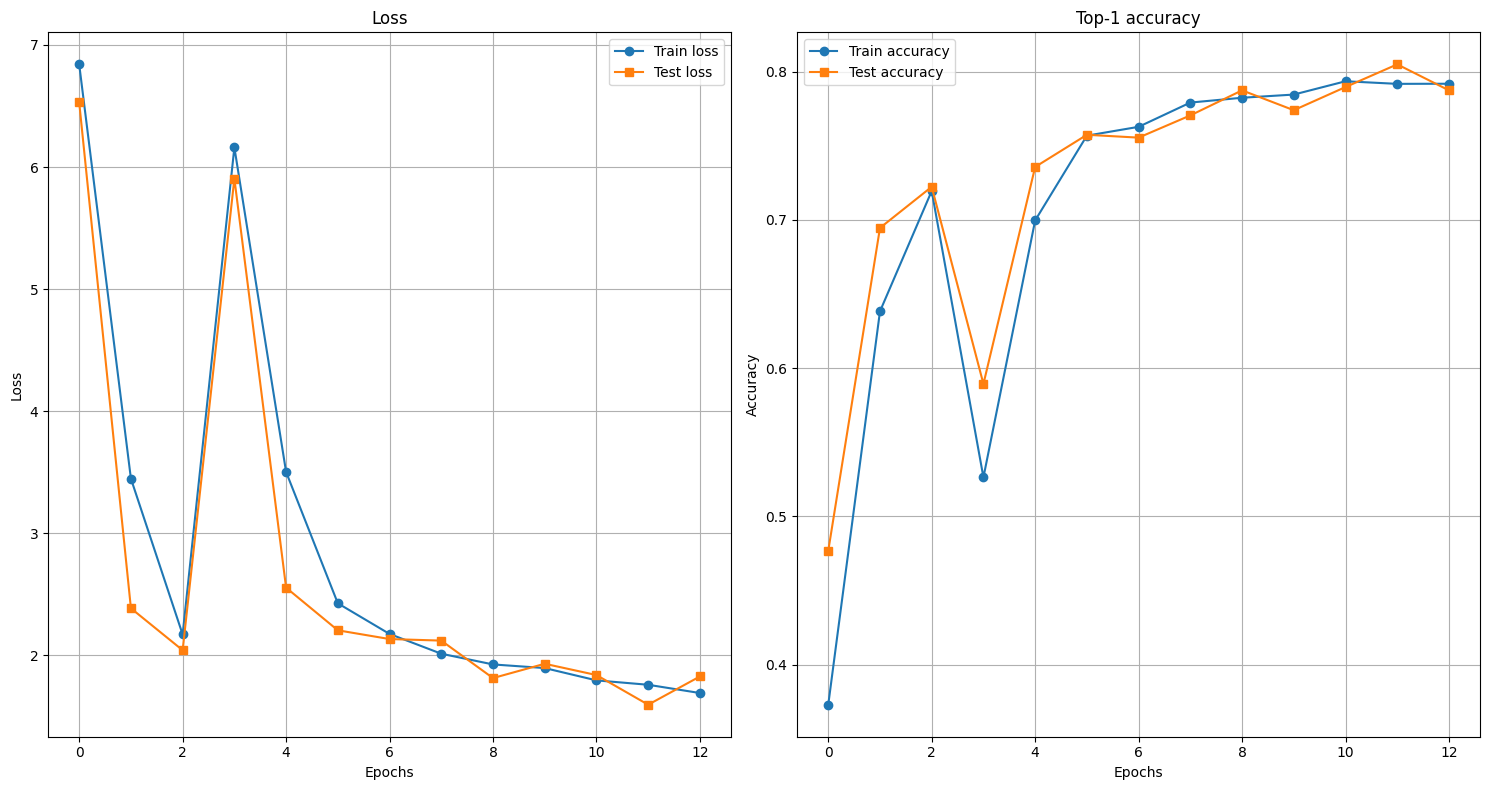

In [ ]:
plot_history(param)